# Importing necessary packages and frameworks

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score

In [2]:
def autoencoder_function(nv, nh, optimizer='adam', loss = 'mean_squared_error', metrics=['accuracy']):
    """
    Main function to define the AE Neural Network
    
    Parameters
    ----------
    nv: TYPE
    nh : TYPE
    optimizer : TYPE, optional
    DESCRIPTION. The default is "adam".
    loss : TYPE, optional
    DESCRIPTION. The default is 'mean_squared_error'.
    metrics : TYPE, optional
    DESCRIPTION. The default is ['accuracy'].
    
    Returns
    -------
    autoencoder: TYPE
    """
    
    #Define input
    input_layer = Input(shape=(nv,))
    
    #Encoding
    encoder = Dense(nh, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_layer)
    
    #Decoding
    decoder = Dense(nv, activation='sigmoid')(encoder)
    
    #Model
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    autoencoder.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return autoencoder

# I. Prepare data
## Disable eager_exec

In [3]:
tf.compat.v1.disable_eager_execution()

## Load & prepare data

In [4]:
df_raw = pd.read_csv('Data_Sources/creditcard.csv').drop(columns=['Time'])

## Plot target variable

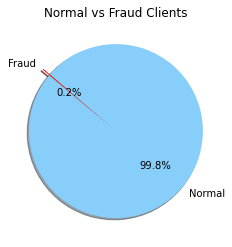

In [5]:
labels = ['Normal', 'Fraud']
sizes = [len(df_raw[df_raw['Class']==0]), len(df_raw[df_raw['Class']==1])]
colors = ['lightskyblue', 'red']
explode = (0, 0.1)
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Normal vs Fraud Clients')
plt.show()

## Normalize

In [6]:
sc = MinMaxScaler(feature_range = (0, 1))
df_raw['Amount'] = sc.fit_transform(df_raw['Amount'].values.reshape(-1, 1))

# II. Supervised
## Train/Eval split

In [7]:
X_train, X_test = train_test_split(df_raw, test_size=0.2, random_state=42)

## Train only in non outliers

In [8]:
X_train = X_train[X_train.Class==0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values

## Parameters

In [9]:
nv = X_train.shape[1] # visible units
nh = 32 # hidden units
epochs = 50
batch_size = 256

## Train AE

In [10]:
model = autoencoder_function(nv, nh, optimizer='adam', loss='mean_squared_error', metrics =['accuracy'])
history = model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, shuffle=True)

Train on 227451 samples
Epoch 1/50
227451/227451 [==============================] - 3s 11us/sample - loss: 0.8499 - accuracy: 0.5993
Epoch 2/50
227451/227451 [==============================] - 2s 10us/sample - loss: 0.7305 - accuracy: 0.7839
Epoch 3/50
227451/227451 [==============================] - 3s 12us/sample - loss: 0.7150 - accuracy: 0.8209
Epoch 4/50
227451/227451 [==============================] - 3s 15us/sample - loss: 0.7080 - accuracy: 0.8630
Epoch 5/50
227451/227451 [==============================] - 3s 12us/sample - loss: 0.7039 - accuracy: 0.8989
Epoch 6/50
227451/227451 [==============================] - 5s 22us/sample - loss: 0.7016 - accuracy: 0.9179
Epoch 7/50
227451/227451 [==============================] - 2s 9us/sample - loss: 0.6990 - accuracy: 0.9247
Epoch 8/50
227451/227451 [==============================] - 4s 19us/sample - loss: 0.6981 - accuracy: 0.9244
Epoch 9/50
227451/227451 [==============================] - 3s 15us/sample - loss: 0.6974 - accuracy: 0.9

## Plot metrics

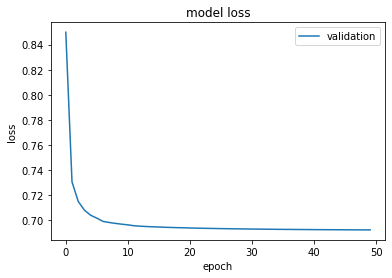

In [11]:
plt_history = history.history
plt.plot(plt_history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation'], loc='upper right')
plt.show()

## Obtain predictions

In [12]:
threshold = 2.9 # Set threshold for reconstruction error

predictions = model.predict(X_test)
se = np.mean(np.power(X_test - predictions, 2), axis = 1)
mse = np.mean(np.power(X_test - predictions, 2), axis = 1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})
error_df.head()

/usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


,reconstruction_error,true_class
43428,80.799711,1
49906,0.709810,0
29474,0.185185,0
276481,0.289815,0
278846,0.166615,0


## Visualize [Chart]

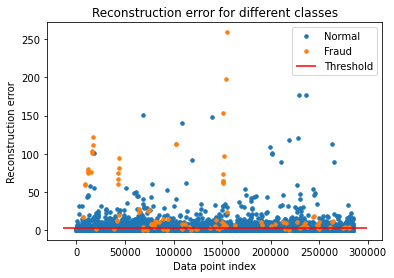

In [13]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index,
            group.reconstruction_error,
            marker='o',
            ms=3.5,
            linestyle='',
            label='Fraud' if name == 1 else 'Normal')
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors='r', zorder=100, label = 'Threshold')
ax.legend()
plt.title('Reconstruction error for different classes')
plt.ylabel('Reconstruction error')
plt.xlabel('Data point index')
plt.show()

## Visualize [CM]

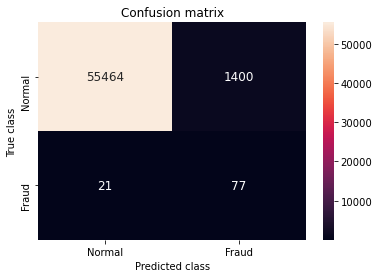

In [14]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt='d', annot_kws={'fontsize':12})
plt.title('Confusion matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [15]:
model.save('Models/model_supervised_AE.h5')

# III. Unsupervised
## Train/Eval split

In [16]:
df_input = df_raw.copy().drop(columns=['Class']) # No class column
X_train, X_test = train_test_split(df_input, test_size=0.2, random_state=42)

## Parameters

In [17]:
nv = X_train.shape[1] #visible units
nh = 32 #hidden units
epochs = 50
batch_size = 256

# Train AE

In [18]:
model = autoencoder_function(nv, nh, optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history = model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, shuffle=True)

Train on 227845 samples
Epoch 1/50
227845/227845 [==============================] - 3s 15us/sample - loss: 0.9018 - accuracy: 0.5876
Epoch 2/50
227845/227845 [==============================] - 4s 19us/sample - loss: 0.7750 - accuracy: 0.7763s - loss: 0.7807 - ac
Epoch 3/50
227845/227845 [==============================] - 4s 17us/sample - loss: 0.7588 - accuracy: 0.8157
Epoch 4/50
227845/227845 [==============================] - 4s 16us/sample - loss: 0.7506 - accuracy: 0.8633
Epoch 5/50
227845/227845 [==============================] - 3s 14us/sample - loss: 0.7457 - accuracy: 0.8977
Epoch 6/50
227845/227845 [==============================] - 3s 13us/sample - loss: 0.7425 - accuracy: 0.9169
Epoch 7/50
227845/227845 [==============================] - 2s 11us/sample - loss: 0.7412 - accuracy: 0.9268
Epoch 8/50
227845/227845 [==============================] - 2s 10us/sample - loss: 0.7404 - accuracy: 0.9279
Epoch 9/50
227845/227845 [==============================] - 2s 9us/sample - loss: 0

## Obtain predictions

In [21]:
threshold = 2.9 # Set threshold for reconstruction error
threshold = 25 # Set threshold for reconstruction error

predictions = model.predict(X_test)
se = np.mean(np.power(X_test - predictions, 2), axis = 1)
mse = np.mean(np.power(X_test - predictions, 2), axis = 1)
error_df = pd.DataFrame({'reconstruction_error': mse})

error_df.head()

,reconstruction_error
43428,80.218306
49906,0.711055
29474,0.185268
276481,0.289870
278846,0.166483


## Visualize [Chart]


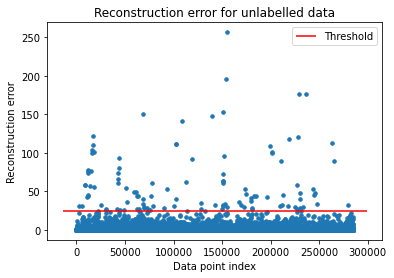

In [22]:
fig, ax = plt.subplots()

ax.plot(error_df.index, error_df.reconstruction_error, marker='o', ms=3.5, linestyle='')
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors='r', zorder=100, label='Threshold')
ax.legend()
plt.title('Reconstruction error for unlabelled data')
plt.ylabel('Reconstruction error')
plt.xlabel('Data point index')
plt.show()

In [23]:
model.save('Models/model_unsupervised_AE.h5')